# RFM Analysis

This notebook contains a Python script for performing RFM (Recency, Frequency, Monetary) analysis on Superstore sales data. The analysis includes:

- Loading and preprocessing the data
- Calculating recency, frequency, and monetary values for each customer
- Determining the optimal number of clusters using the elbow method
- Clustering customers using K-means

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## Load Data
Load the dataset from a CSV file.

In [4]:
def load_data(file_path):
    """Load the dataset from a CSV file."""
    return pd.read_csv(file_path, sep=';')

file_path = r"C:\Users\Faezeh\Desktop\portfolio\Non-EU-Training-Datasets\Non-EU Training Datasets\Tableau-Sales-Dataset-Big\Orders.csv"
orders = load_data(file_path)
orders.head()

,Order_ID,Customer_ID,Product_ID,Order_Date,Shipping_Date,Sales,Quantity,Discount,Profit,Unit_Price
0,1,89,1566,29/03/2019,04/04/2019,79.4000,5,0.20,5.9550,15.6800
1,2,244,343,14/07/2019,23/07/2019,375.4575,3,0.45,-157.0095,124.7025
2,3,291,558,01/02/2019,18/02/2019,23.7600,3,0.20,2.0790,7.7200
3,4,613,1135,13/03/2019,23/03/2019,142.4000,5,0.00,52.6880,28.4800
4,5,390,641,15/10/2019,02/11/2019,94.8500,5,0.00,45.5280,18.9700


## Preprocess Data
To calculate RFM (Recency, Frequency, Monetary) values for each customer, we follow these steps:

**Recency:** This measures how recently a customer made a purchase.

- Step 1: Find the most recent order date for each customer.
- Step 2: Calculate the number of days since the last purchase to a specific date (e.g., today's date or any chosen date). This is done by subtracting the last order date from the specific date. The result is the recency value.

**Frequency:** This measures how often a customer makes a purchase.

- Step 1: Count the total number of orders made by each customer. This count is the frequency value.

**Monetary:** This measures how much money a customer has spent.

- Step 1: Sum up the total sales for each customer. This total amount spent is the monetary value.

In [5]:
def preprocess_data(df):
    """Preprocess the data by converting date columns and calculating recency, frequency, monetary."""
    df['Order_Date'] = pd.to_datetime(df['Order_Date'])
    max_order_date = df.groupby('Customer_ID')['Order_Date'].max().reset_index()
    max_order_date['Order_Date'] = pd.to_datetime(max_order_date['Order_Date'])
    specific_date = pd.to_datetime('2022-12-30')
    max_order_date['recency'] = (specific_date - max_order_date['Order_Date']).dt.days
    recency = max_order_date[['Customer_ID', 'recency']]
    frequency = df.groupby('Customer_ID')['Order_ID'].count().reset_index().rename(columns={'Order_ID': 'frequency'})
    monetary = df.groupby('Customer_ID')['Sales'].sum().reset_index().rename(columns={'Sales': 'monetary'})
    return recency, frequency, monetary

In [10]:
recency, frequency, monetary = preprocess_data(orders)
print(recency.head())
print(frequency.head())
print(monetary.head())

   Customer_ID  recency
0            1      151
1            2      138
2            3       42
3            4      122
4            5       15
   Customer_ID  frequency
0            1         16
1            2         12
2            3         18
3            4         13
4            5         18
   Customer_ID  monetary
0            1  3768.446
1            2  1030.740
2            3  4755.704
3            4  2275.868
4            5  2481.554


## Calculate WCSS
Calculate the within-cluster sum of squares for different values of K.


In [12]:
def calculate_wcss(data):
    """Calculate the within-cluster sum of squares for different values of K."""
    wcss = []
    k_range = range(1, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(data.reshape(-1, 1))
        wcss.append(kmeans.inertia_)
    return wcss

# Example usage
wcss_recency = calculate_wcss(recency['recency'].values)
wcss_frequency = calculate_wcss(frequency['frequency'].values)
wcss_monetary = calculate_wcss(monetary['monetary'].values)

In [13]:
print(wcss_recency)
print(wcss_frequency)
print(wcss_monetary)

[5015440.48, 2092969.528035498, 1019957.7433701891, 586356.197596089, 380266.927369688, 274491.4929093782, 195027.905669423, 147396.31472057546, 113640.03564160326, 91283.38738925141]
[12006.43875, 4645.4622233495265, 2364.20477301763, 1512.9747343760234, 1015.0086654884441, 673.9919709334916, 489.57686812159227, 391.8938621691667, 334.3688481982007, 273.50012074437836]
[6694689753.994027, 3155147866.676499, 1575323222.0900273, 846741539.0693847, 508165346.2725502, 354493787.0830832, 256375029.9855129, 204817245.06079078, 161192459.01355666, 131026326.93544927]


## Plot Elbow Curve
Plot the elbow curve to find the optimal number of clusters.


In [14]:
def plot_elbow_curve(wcss, title):
    """Plot the elbow curve to find the optimal number of clusters."""
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
    plt.title(title)
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.show()


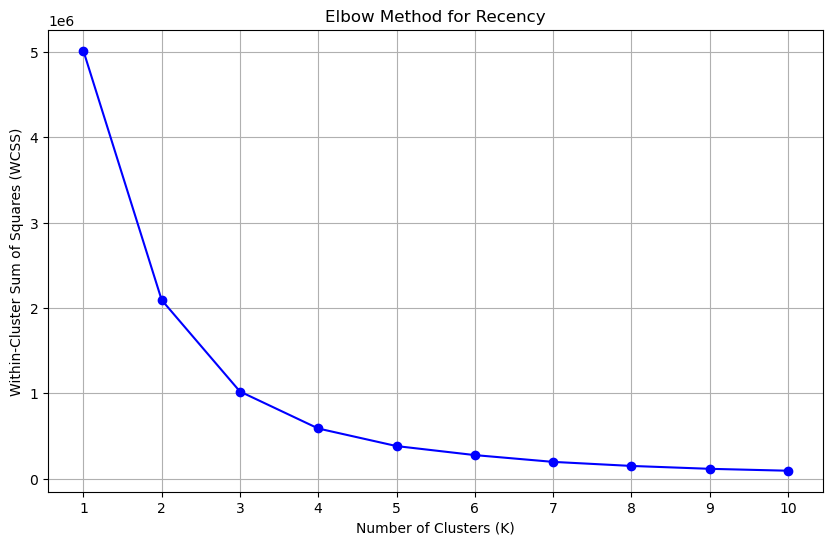

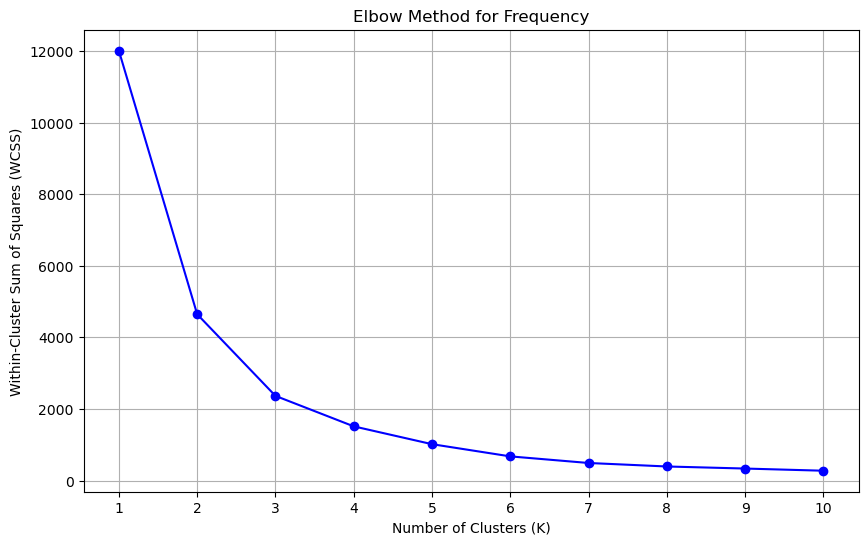

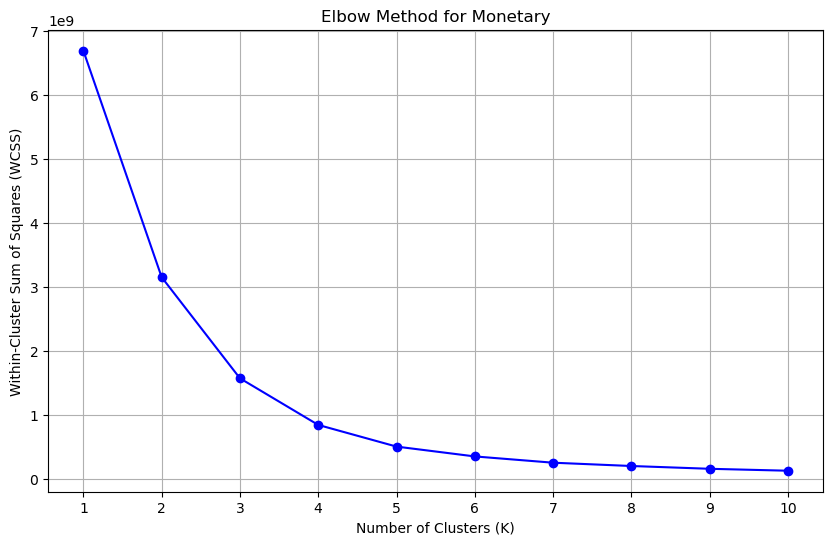

In [15]:
plot_elbow_curve(wcss_recency, 'Elbow Method for Recency')
plot_elbow_curve(wcss_frequency, 'Elbow Method for Frequency')
plot_elbow_curve(wcss_monetary, 'Elbow Method for Monetary')

## Combine RFM Data
Combine recency, frequency, and monetary data into a single DataFrame.

In [ ]:
# Combine RFM into a single DataFrame
rfm = recency.merge(frequency, on='Customer_ID').merge(monetary, on='Customer_ID')
rfm.head()

## K-means Clustering
### Determine intervals for each cluster
Determine the optimal number of clusters and perform K-means clustering.

In [18]:
import numpy as np
from sklearn.cluster import KMeans

optimal_k = {"recency": 5, "frequency": 5, "monetary": 5}
values_ = {"recency": recency['recency'].values,
           "frequency": frequency['frequency'].values,
           "monetary": monetary['monetary'].values}

for key, value in optimal_k.items():
    data = values_[key]
    # Fit K-Means with the optimal number of clusters
    kmeans = KMeans(n_clusters=value, n_init=10)  # Set n_init explicitly to suppress the warning
    kmeans.fit(data.reshape(-1, 1))

    # Get cluster centers and labels
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    # Determine intervals for each cluster
    cluster_intervals = []
    for i in range(value):
        cluster_points = data[labels == i]
        min_value = np.min(cluster_points)
        max_value = np.max(cluster_points)
        cluster_intervals.append((min_value, max_value))
    cluster_intervals = sorted(cluster_intervals, key=lambda x: x[0])

    print("Optimal number of clusters {:s}:\t{}".format(key, value))
    print("Cluster intervals:\n", cluster_intervals)
    print("\n")

Optimal number of clusters recency:	5
Cluster intervals:
 [(-1, 41), (42, 96), (97, 180), (188, 352), (370, 715)]


Optimal number of clusters frequency:	5
Cluster intervals:
 [(4, 10), (11, 13), (14, 16), (17, 20), (21, 29)]


Optimal number of clusters monetary:	5
Cluster intervals:
 [(223.728, 2605.183), (2611.828, 4803.567), (4851.581, 8389.264000000001), (8739.266, 16882.42), (18528.137, 28474.509)]




## create RFM Dataframe


In [23]:
# Assuming your RFM dataframe is named 'rfm'

# Define the cluster intervals
recency_intervals = [(-1, 41), (42, 96), (97, 180), (188, 352), (370, 715)]
frequency_intervals = [(4, 10), (11, 13), (14, 16), (17, 20), (21, 29)]
monetary_intervals = [(223.728, 2605.183), (2611.828, 4803.567), (4851.581, 8389.264000000001),
                      (8739.266, 16882.42), (18528.137, 28474.509)]

# Define a function to assign cluster numbers
def assign_cluster_number(value, intervals):
    for i, interval in enumerate(intervals, start=1):
        if interval[0] <= value <= interval[1]:
            return i
    return 0  # Return 0 if value doesn't fall into any interval

# Assign cluster numbers for recency, frequency, and monetary columns
rfm = pd.DataFrame(columns=['Customer_ID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score'])

rfm['Customer_ID'] = orders['Customer_ID']
rfm['Recency'] = recency['recency'].apply(lambda x: assign_cluster_number(x, recency_intervals))
rfm['Frequency'] = frequency['frequency'].apply(lambda x: assign_cluster_number(x, frequency_intervals))
rfm['Monetary'] = monetary['monetary'].apply(lambda x: assign_cluster_number(x, monetary_intervals))
rfm['RFM_Score'] = round((rfm['Recency'] + rfm['Frequency'] + rfm['Monetary'])/ 3)

# Checking the result
print(rfm.head())

   Customer_ID  Recency  Frequency  Monetary  RFM_Score
0           89      3.0        3.0       2.0        3.0
1          244      3.0        2.0       1.0        2.0
2          291      2.0        4.0       2.0        3.0
3          613      3.0        2.0       1.0        2.0
4          390      1.0        4.0       1.0        2.0
